In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import iceplant_detection_functions as ipf

In [2]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
aoi = aois.iloc[4]  # Dangermonf aoi

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


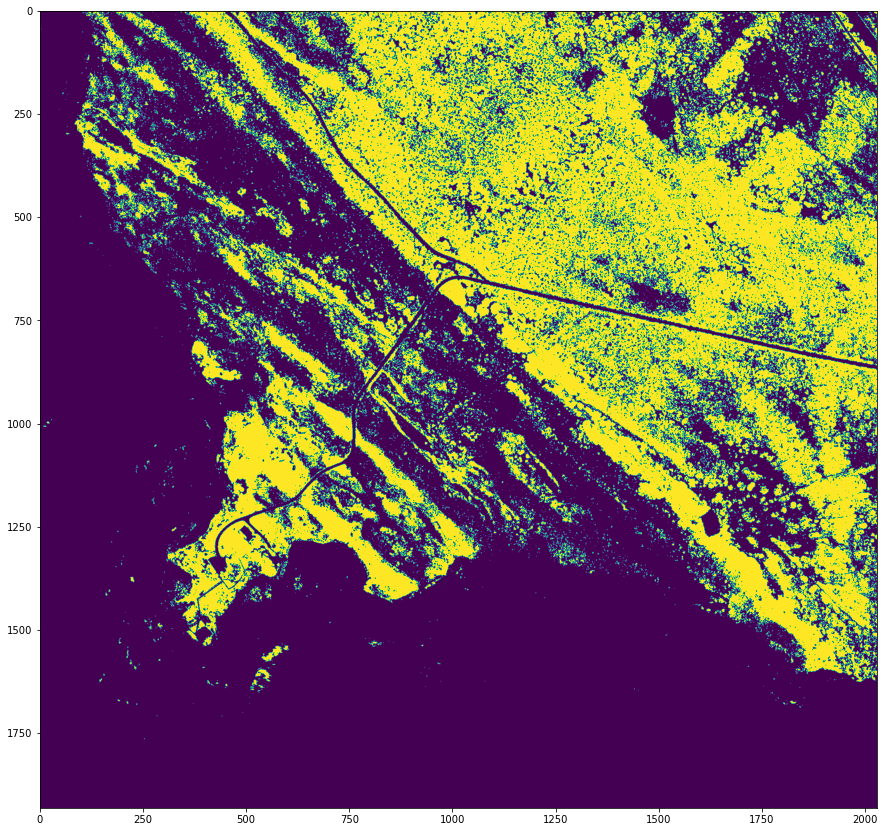

In [3]:
dangermond_veg = ipf.select_ndvi_image(aoi.itemid, aoi.geometry)
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(dangermond_veg)
plt.show()

In [4]:
fp = os.path.join(os.getcwd(),'training_set','aux_data','dangermond_and_campuspoint.csv')
features_df = pd.read_csv(fp)

features_df.drop(['geometry','Unnamed: 0','x','y','day','year'],axis=1,inplace=True)
features_df
ipf.iceplant_counts(features_df)          

,iceplant,count
0,0,8784
1,1,5567


In [5]:
train_features, test_features, train_labels, test_labels = ipf.test_train_from_df(features_df)

#ipf.train_test_shapes(train_features, train_labels, test_features, test_labels)
#ipf.test_train_proportions(train_labels, test_labels)

rfc_balanced = RandomForestClassifier(n_estimators = 150, 
                                      random_state = 42,
                                      class_weight='balanced')
rfc_balanced.fit(train_features,train_labels)
predictions_balanced = rfc_balanced.predict(test_features)
#ipf.print_rfc_evaluation(rfc_balanced, test_features, test_labels, predictions_balanced)

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
/tmp/ipykernel_1696/3534713989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veg['month']=9   # manually add date


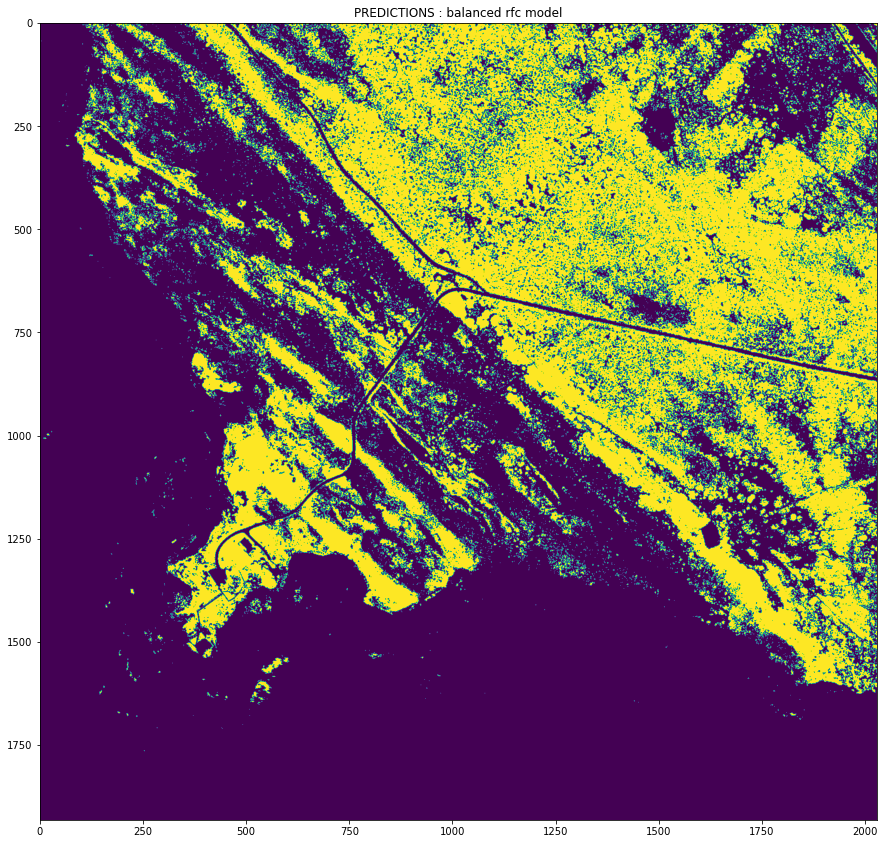

In [6]:
image = ipf.open_window_in_scene(aoi.itemid, aoi.geometry)
veg = ipf.select_ndvi_df(image)
veg['month']=9   # manually add date

index = veg.index
features = np.array(veg)

predictions_class = rfc_balanced.predict(features)

c = {'prediction':predictions_class}
predictions_df = pd.DataFrame(c, index = index)


predictions = ipf.df_backto_image(image,predictions_df)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : balanced rfc model")
ax.imshow(predictions)
plt.show()